### Import packages and functions

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import colors

import glob
plt.rcParams['figure.figsize'] = (12, 6)

# add the other files
import sys
# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from aste_helper_funcs import *

### Set up the grid and sample files from the official ASTE

In [2]:
#on sverdrup:
dir_grid='/scratch/atnguyen/aste_270x450x180/GRID_real8/'
dir_cur = '/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/'
dirdiags = dir_cur + "diags/"

In [3]:
nx=270
ncut1=450
ncut2=180
ny=2*ncut1+nx+ncut2
nz=50
nfx=5*nx
nfy=5*nx
nfx=[nx,0,nx,ncut2,ncut1]
nfy=[ncut1,0,nx,nx,nx]
print(nfx)
print(nfy)

[270, 0, 270, 180, 450]
[450, 0, 270, 270, 270]


In [4]:
mygrid = {
    'dirGrid': dir_grid,
    'nFaces': 5,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

In [5]:
#test to read a binary file from scratch, here we have to know
#that the file is float32, and the syntax reads in the entire
#file, so can be very dangerous if the file is very big:
filename = dir_grid + 'Depth.data'
with open(filename, 'rb') as f:
    data = np.fromfile(f, dtype=np.dtype('>f8')) #this is the syntax for: f=float32, f8=float64 with big-endian order
    dep = np.reshape(data, [ny, nx]) #(729000,) = (1170*90, ) --> (1170, 90), <class 'numpy.ndarray'>
print(np.shape(dep))

(1350, 270)


### Demonstrate get_aste_tracer and aste_tracer2compact
We read in depth as compact form. This is plottable but not readable. See below.

In [6]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',21).copy()
cmap.set_under(color='white')

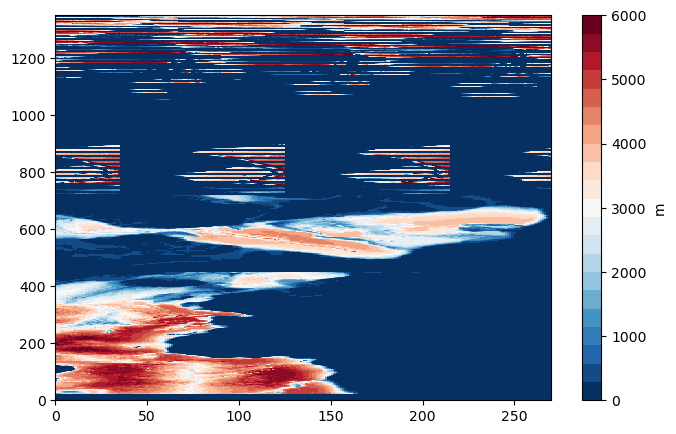

In [7]:
# 
fig = plt.figure(figsize=(8,5))
plt.pcolormesh(dep,cmap=cmap)
plt.colorbar(label="m")

We can use get_aste_tracer to view this in a more legible form:

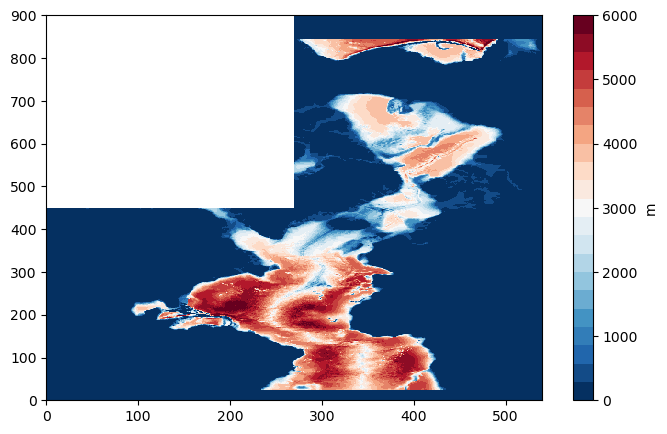

In [8]:
dep_tracer = get_aste_tracer(dep,nfx,nfy)
fig = plt.figure(figsize=(8,5))
plt.pcolormesh(dep_tracer[0],cmap=cmap)
plt.colorbar(label="m")

If we want to go back and forth, we can then use aste_tracer2compact:

shape of tracer fld: (1, 900, 540)
(1, 1350, 270)
compact shape (1, 1350, 270)


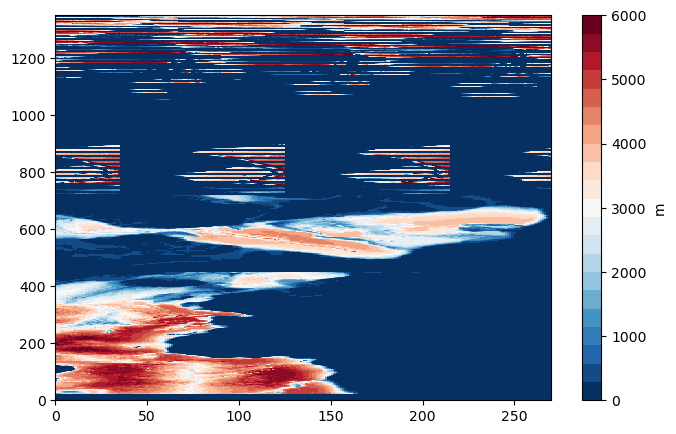

In [9]:
fig = plt.figure(figsize=(8,5))
dep_compact = aste_tracer2compact(dep_tracer,nfx,nfy)
plt.pcolormesh(dep_compact[0],cmap=cmap)
plt.colorbar(label="m")

This should be the same as our original depth. Let's prove it:

In [10]:
np.nansum(dep-dep_compact)

0.0

### Demonstrate reading binary file

In [11]:
filename = dir_grid + 'Depth.data'
dep1=read_aste_float64(filename,nx,ny,1)

filename = dir_grid + 'hFacC.data'
hfc=read_aste_float64(filename,nx,ny,nz)

Let's prove this read_aste_float64 depth is the same as the depth we read before. Should be 0:

In [12]:
print(np.sum(dep1-dep))

0.0


### Demonstrate get_aste_faces and aste_faces2compact

We just read in the compact form of depth (not the tracer form, remember). Sample get_aste_faces from the COMPACT:

In [13]:
fldout=get_aste_faces(dep,nfx,nfy)
print(type(fldout))                #<class '__main__.structtype'>
print(np.shape(fldout))            #()
print(np.shape(fldout.f1))         #(1, 450, 270)
print(np.shape(fldout.f3))         #(1, 270, 270)
print(np.shape(fldout.f4))         #(1, 270, 180)
print(np.shape(fldout.f5))         #(1, 270, 450)
print(type(fldout.f1))             #<class 'numpy.ndarray'>

nx 270
sz [1350  270]
(1, 1350, 270)
tmp (1, 450, 270)
<class 'aste_helper_funcs.structtype'>
()
(1, 450, 270)
(1, 270, 270)
(1, 270, 180)
(1, 270, 450)
<class 'numpy.ndarray'>


We can plot this using plot_aste_faces:

nx 270
sz [1350  270]
(1, 1350, 270)
tmp (1, 450, 270)
500


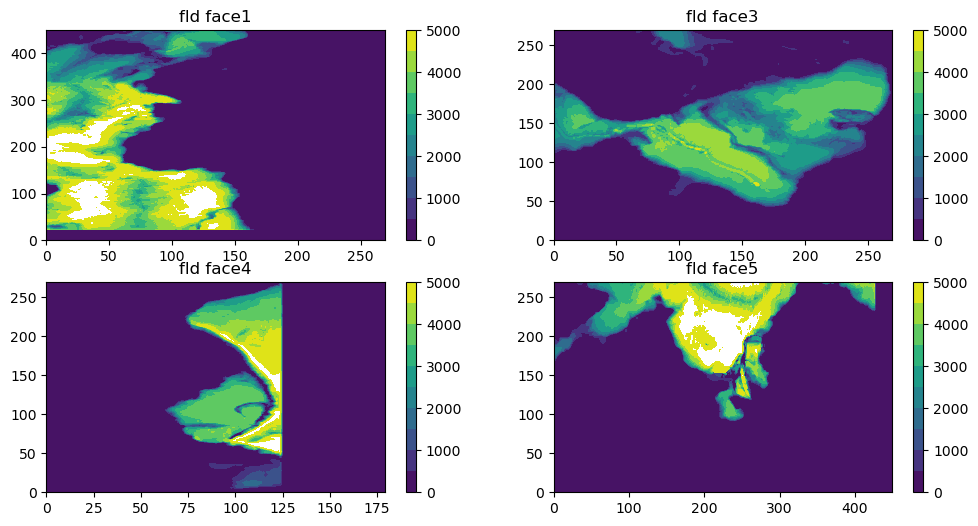

In [14]:
climit=np.array([0,5500])
klev=1
plot_aste_faces(dep,nfx,nfy,klev,climit,500)

nx 270
sz [1350  270]
(1, 1350, 270)
tmp (1, 450, 270)
0.5


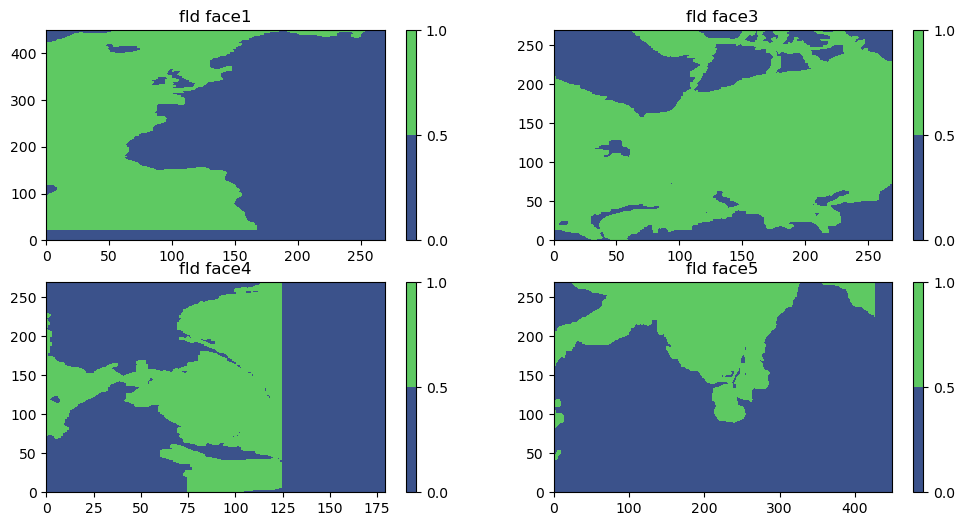

In [15]:
climit=np.array([0,1.5])
klev=1
plot_aste_faces(hfc[0,:,:],nfx,nfy,klev,climit,0.5)

Can we compare this using aste_faces2compact(fld,nfx,nfy)? If we made testout as tracer form from dep, we should be able to compare it to our original array using a nansum:

In [16]:
testout = aste_faces2compact(fldout,nfx,nfy)
np.nansum(testout[0]-dep)

(1, 1350, 270)


0.0

Read some more files just in case we didn't understand how to do it the first time:

In [17]:
filename = dir_grid + 'DXG.data'
dxg=read_aste_float64(filename,nx,ny,1)
    
filename = dir_grid + 'DYG.data'
dyg=read_aste_float64(filename,nx,ny,1)

filename = dir_grid + 'DRF.data'
with open(filename, 'rb') as f:
    drf = np.fromfile(f, dtype=np.dtype('>f8')) #this is the syntax for f=float32,f8=float64 with big-endian order
    #print(drf.shape) #(50,), <class 'numpy.ndarray'>
print(dxg.shape),print(dyg.shape), print(dep.shape),print(drf.shape)

(1350, 270)
(1350, 270)
(1350, 270)
(50,)


(None, None, None, None)

### What about vector data? Can we plot that using get_aste_vector?

In [18]:
# first set up with files, we're using advection because these need to be vectors
meta=parsemeta(dirdiags + "TRSP/trsp_2d_set1.0000438048.meta")
fldList = meta["fldList"]
desiredflds = ["ADVx_TH","ADVy_TH"]
print(fldList)
recs = [fldList.index(item) for item in desiredflds if item in fldList]    # get the record numbers for rdmds
print(recs)

['DFxE_TH', 'DFyE_TH', 'ADVx_TH', 'ADVy_TH', 'DFxE_SLT', 'DFyE_SLT', 'ADVx_SLT', 'ADVy_SLT']
[2, 3]


In [19]:
u = rdmds(dirdiags + "TRSP/" + "trsp_2d_set1",438048,rec = recs[0])      # 4050 x 90
u = u.reshape(ny,nx)                                                     # 1350 x 270

v = rdmds(dirdiags + "TRSP/" + "trsp_2d_set1",438048,rec = recs[1])      # 4050 x 90
v = v.reshape(ny,nx)                                                     # 1350 x 270

In [20]:
fldstr3d = ['hFacW','hFacS']

for fld in fldstr3d:
    Fac_fld = rdmds(os.path.join(dir_grid, fldstr3d[fldstr3d.index(fld)]))
    print(Fac_fld.reshape(nz, ny, nx).shape)
    mygrid[fld] = Fac_fld.reshape(nz, ny, nx)                            # 50 x 1350 x 270

(50, 1350, 270)
(50, 1350, 270)


In [21]:
uaste,vaste = get_aste_vector(u,v,nfx,nfy,False)

In [22]:
hfw = mygrid["hFacW"]
hfs = mygrid["hFacS"]
hfwaste,hfsaste=get_aste_vector(hfw,hfs,nfx,nfy,True)

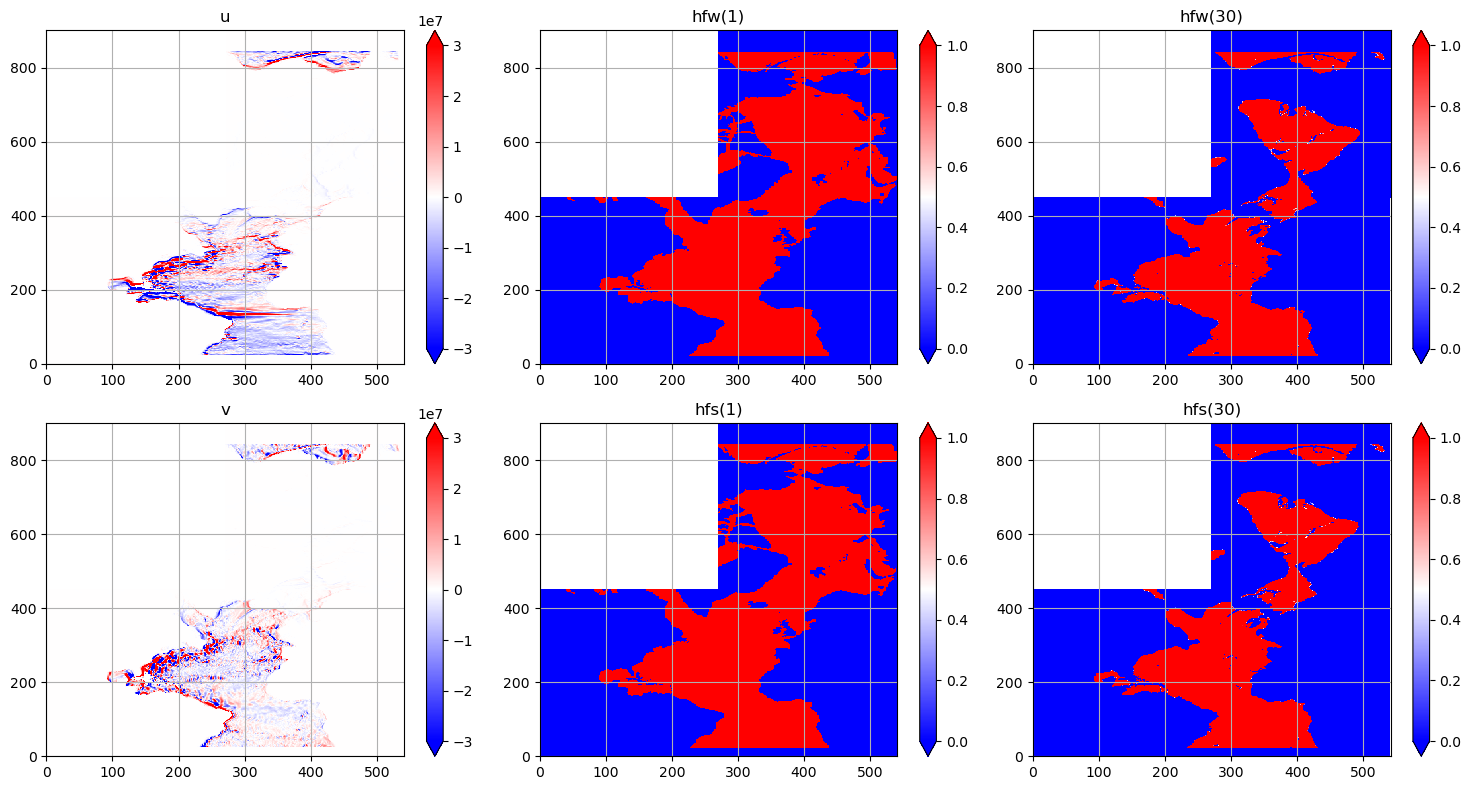

In [23]:
# Plotting uaste
plt.figure(1,figsize=(15,8))
plt.clf()
plt.subplot(2, 3, 1)
hh = plt.pcolormesh(uaste[0],cmap = "bwr",vmax=3e7,vmin=-3e7)
plt.colorbar(hh, extend='both')
plt.grid()
plt.title('u')

# Plotting vaste
plt.subplot(2, 3, 4)
hh = plt.pcolormesh(vaste[0],cmap = "bwr",vmax=3e7,vmin=-3e7)
plt.colorbar(hh, extend='both')
plt.grid()
plt.title('v')

# Plotting hfwaste(1)
plt.subplot(2, 3, 2)
hh = plt.pcolor(hfwaste[0,:,:],cmap = "bwr")                 # first layer in depth
plt.colorbar(hh, extend='both')
plt.grid()
plt.title('hfw(1)')

# # Plotting hfsaste(1)
plt.subplot(2, 3, 5)
hh = plt.pcolor(hfsaste[0,:,:],cmap = "bwr")                 # first layer in depth
plt.colorbar(hh, extend='both')
plt.grid()
plt.title('hfs(1)')

# # Plotting hfwaste(30)
plt.subplot(2, 3, 3)
hh = plt.pcolor(hfwaste[30,:,:],cmap = "bwr")                 # 30th layer in depth
plt.colorbar(hh, extend='both')
plt.grid()
plt.title('hfw(30)')

# # Plotting hfsaste(30)
plt.subplot(2, 3, 6)
hh = plt.pcolor(hfsaste[30,:,:],cmap = "bwr")                 # 30th layer in depth
plt.colorbar(hh, extend='both')
plt.grid()
plt.title('hfs(30)')

plt.tight_layout()
# plt.savefig("test_example_get_vector.png",dpi=300)
plt.show()